In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# import

In [2]:
# export
from fastai.basic_train import LearnerCallback

In [3]:
# export
from fastai.callbacks.general_sched import *
from fastai.callback import *

In [4]:
# export
from fastai.core import *

In [5]:
# export
from IPython.core import debugger as idb

In [6]:
from torch.utils.tensorboard import SummaryWriter

In [7]:
# export
from exp import nb_resnet_unet
from exp import nb_loss_metrics
from exp import nb_optimizer
from exp import nb_tensorboard_callback
from exp import nb_scheduling_train
from exp import nb_databunch
from exp import nb_train_script_logger

In [8]:
# export
import torch

In [9]:
# export
from torch import tensor

In [10]:
# export
from torch import nn

In [11]:
# export
from torch.nn import Sequential, ModuleList

In [12]:
# export
from fastai.basic_train import Learner

In [13]:
# export
from fastai.torch_core import bn_types,bias_types

In [14]:
# export
from functools import partial

In [15]:
# export
import os,shutil

In [16]:
# export
from fastai.callbacks import CSVLogger

In [17]:
# export
from fastai.callbacks.tracker import SaveModelCallback

In [18]:
import shutil

# functions

In [57]:
# export
def get_learn(data, model_name = 'resnet18', allres = True
              , loss_func_name = 'balance_bce', balance_ratio = 1
              , tag = None):
    assert model_name in ['resnet18', 'assert34'], 'invalid model name'
    assert loss_func_name in ['balance_bce', 'dice_loss', 'combo_loss'], 'invalid loss func name'
    #检查一下确保参数没写错
    assert tag is not None
    if tag is not None:
        #tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset200', 'adam'])
        tags = tag.split('__')
        assert model_name == tags[0]
        assert tags[1] in ['allres', 'vanila']
        assert (allres and tags[1] == 'allres') or (not allres and tags[1] == 'vanila')
        if loss_func_name == 'dice_loss':
            assert  len(tags) == 5
        else:
            assert  len(tags) == 6
            assert (tags[5] == 'balance_ratio_1' and balance_ratio == 1) \
                    or (tags[5] == 'balance_ratio_10' and balance_ratio == 10) \
                    or (tags[5] == 'balance_ratio_0.1' and balance_ratio == 0.1)
            
    # create model
    model = None
    if model_name == 'resnet18':
        model = nb_resnet_unet.get_unet_res18(1, allres)
        if allres:
            model.load_state_dict(torch.load('./models/unet_res18_allres_init.pth'))
        else:
            model.load_state_dict(torch.load('./models/unet_res18_vanila_init.pth'))
    elif model_name == 'resnet34':
        model = nb_resnet_unet.get_unet_res34(1, allres)
        if allres:
            model.load_state_dict(torch.load('./models/unet_res34_allres_init.pth'))
        else:
            model.load_state_dict(torch.load('./models/unet_res34_vanila_init.pth'))
    
    # create learner
    learn = Learner(data,model)
    
    # split model
    learn.layer_groups = nb_train_script_logger.split_model(learn.model)
    
    # set multi-gpu
    if data.device.type=='cuda':
        learn.model = torch.nn.DataParallel(learn.model,device_ids=[0,1,2,3,4,5])
        
    # set loss func
    if loss_func_name == 'combo_loss':
        learn.loss_func = partial(nb_loss_metrics.combo_loss, balance_ratio=balance_ratio)
    elif loss_func_name == 'dice_loss':
        learn.loss_func = nb_loss_metrics.dice_loss
    elif loss_func_name == 'balance_bce':
        learn.loss_func = partial(nb_loss_metrics.balance_bce, balance_ratio=balance_ratio)
    
    # 添加metrics
    learn.metrics += [nb_loss_metrics.dice_loss]
    learn.metrics += [partial(nb_loss_metrics.balance_bce,balance_ratio=1)]
    learn.metrics += [nb_loss_metrics.mask_iou]
    
    return learn

In [20]:
#export
model_names = ['resnet18', 'assert34']
loss_func_names = ['dice_loss', 'balance_bce', 'combo_loss']
balance_ratios = [1, 0.1, 10]
dataset_dirs = ['data/dataset_20200715', 'data/dataset_20200715_2000', 'data/dataset_20200715_200_et']
dataset_names = ['dataset200', 'dataset2000', 'dataset200_et']

In [21]:
#把结果备份一下
def backup_train_logs(tag, dst_root = 'train_logs'):    
    src_dirs = ['run_log', 'tb_log']
    path = os.path.join(dst_root, tag)
    os.makedirs(path, exist_ok = True)
    for d in src_dirs:        
        dst = os.path.join(dst_root, tag, d)
        #3.8的python才有dirs_exist_ok。现在只能先删掉
        shutil.rmtree(dst, ignore_errors = True)
        shutil.copytree(d, dst)
    ds = tag.split('__')[3]
    assert ds in dataset_names, ds + '???'
    csvpath = dataset_dirs[dataset_names.index(ds)] + '/image'
    shutil.rmtree(os.path.join(path, 'csv_log'), ignore_errors = True)
    #print(os.path.join(csvpath, 'csv_log'), path)
    shutil.copytree(os.path.join(csvpath, 'csv_log'), os.path.join(path, 'csv_log'))

# test

In [22]:
# export
# 设置device
device = torch.device('cuda')

In [23]:
BS = 16

In [68]:
# 200数据集
ds = './data/dataset_20200715'
data_200 = nb_databunch.get_databunch(ds, bs=BS, device=device, transforms = None) 

In [69]:
# 2000数据集
ds = './data/dataset_20200715_2000'
data_2000 = nb_databunch.get_databunch(ds, bs=BS, device=device, transforms = None) 

In [70]:
# 200带elastic_transform数据集
ds = './data/dataset_20200715_200_et'
data_200et = nb_databunch.get_databunch_et(ds, bs=BS, device=device, transforms = None) 

In [71]:
optf_adam = partial(nb_optimizer.Adam, betas=(0.9,0.99))

## 数据集比较

### 200数据集，无transform,resnet18，allres,dice,adam

In [63]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset200', 'adam'])

In [64]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True, tag = tag)

In [74]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_2000/image;

Valid: LabelList (400 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_2000/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


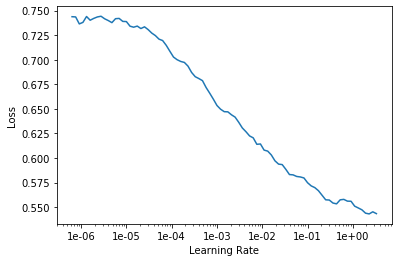

In [64]:
learn = getlearn()
learn.opt_func = optf_adam
learn.lr_find()
learn.recorder.plot()

In [71]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.610610,0.755079,0.755079,0.668652,0.213382,00:22
1,0.559654,0.695043,0.695043,0.564333,0.324456,00:22
2,0.537154,0.603292,0.603292,0.600829,0.324799,00:22
3,0.520687,0.533004,0.533004,0.804303,0.349211,00:22
4,0.501595,0.510433,0.510433,0.967319,0.359203,00:22
5,0.475195,0.396737,0.396737,0.674145,0.466871,00:22
6,0.437727,0.281640,0.281640,0.715841,0.577688,00:22
7,0.399568,0.292850,0.292850,1.086517,0.558671,00:22
8,0.365667,0.230956,0.230956,0.586369,0.655903,00:22
9,0.336315,0.190047,0.190047,0.652293,0.690253,00:22


Better model found at epoch 0 with valid_loss value: 0.755079448223114.
Better model found at epoch 1 with valid_loss value: 0.695042610168457.
Better model found at epoch 2 with valid_loss value: 0.6032920479774475.
Better model found at epoch 3 with valid_loss value: 0.5330035090446472.
Better model found at epoch 4 with valid_loss value: 0.5104333162307739.
Better model found at epoch 5 with valid_loss value: 0.3967370092868805.
Better model found at epoch 6 with valid_loss value: 0.2816401720046997.
Better model found at epoch 8 with valid_loss value: 0.230955570936203.
Better model found at epoch 9 with valid_loss value: 0.19004663825035095.
Better model found at epoch 12 with valid_loss value: 0.16728903353214264.
Better model found at epoch 14 with valid_loss value: 0.1649456024169922.
Better model found at epoch 15 with valid_loss value: 0.1338915377855301.
Better model found at epoch 17 with valid_loss value: 0.13074588775634766.
Better model found at epoch 18 with valid_loss 

In [82]:
backup_train_logs(tag)

In [ ]:
epochs:240,train_loss:0.012935,mask_iou:0.922264

### 2000数据集，无transform,resnet18，allres,dice,adam

In [66]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset2000','adam'])

In [72]:
getlearn = partial(get_learn, data = data_2000, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True, tag = tag)

In [73]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (1600 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_2000/image;

Valid: LabelList (400 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_2000/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


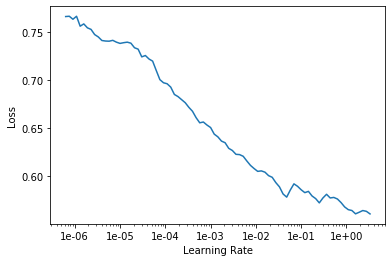

In [83]:
learn = getlearn()
learn.opt_func = optf_adam
learn.lr_find()
learn.recorder.plot()

In [89]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.343741,0.275967,0.275967,0.832594,0.578787,04:02
1,0.190607,0.110784,0.110784,0.578189,0.803420,04:02
2,0.118330,0.097209,0.097209,0.600622,0.824674,04:00
3,0.089307,0.072525,0.072525,0.420103,0.866379,04:00
4,0.075614,0.068155,0.068155,0.291228,0.873257,04:00
5,0.068708,0.084531,0.084531,0.352046,0.845168,04:00
6,0.063752,0.056669,0.056669,0.503608,0.894085,03:59
7,0.056909,0.052714,0.052714,0.460271,0.900575,04:00
8,0.052214,0.048201,0.048201,0.344029,0.908381,04:00
9,0.052278,0.073633,0.073633,0.760601,0.863644,04:00


Better model found at epoch 0 with valid_loss value: 0.27596670389175415.
Better model found at epoch 1 with valid_loss value: 0.11078394204378128.
Better model found at epoch 2 with valid_loss value: 0.09720931947231293.
Better model found at epoch 3 with valid_loss value: 0.07252483069896698.
Better model found at epoch 4 with valid_loss value: 0.06815541535615921.
Better model found at epoch 6 with valid_loss value: 0.05666894093155861.
Better model found at epoch 7 with valid_loss value: 0.05271410942077637.
Better model found at epoch 8 with valid_loss value: 0.048200543969869614.
Better model found at epoch 10 with valid_loss value: 0.043685805052518845.
Better model found at epoch 11 with valid_loss value: 0.03827884420752525.
Better model found at epoch 12 with valid_loss value: 0.036419838666915894.
Better model found at epoch 15 with valid_loss value: 0.031563516706228256.
Better model found at epoch 19 with valid_loss value: 0.030112363398075104.
Better model found at epoch 

Better model found at epoch 221 with valid_loss value: 0.008396374993026257.
Better model found at epoch 223 with valid_loss value: 0.008363435044884682.
Better model found at epoch 226 with valid_loss value: 0.008266935124993324.
on end of epoch#226: start annealing from 0.0001 to 1e-05
Better model found at epoch 227 with valid_loss value: 0.008151202462613583.
Better model found at epoch 228 with valid_loss value: 0.008087804540991783.
Better model found at epoch 234 with valid_loss value: 0.008083577267825603.
Better model found at epoch 236 with valid_loss value: 0.008028528653085232.
Better model found at epoch 238 with valid_loss value: 0.008004915900528431.
Better model found at epoch 241 with valid_loss value: 0.008002088405191898.
Better model found at epoch 245 with valid_loss value: 0.008000807836651802.
Better model found at epoch 250 with valid_loss value: 0.007980945520102978.
Better model found at epoch 253 with valid_loss value: 0.007964667864143848.
on end of epoch#25

In [110]:
backup_train_logs(tag)

In [ ]:
epochs:256,train_loss:0.002,mask_iou:0.984

### 200_et数据集，无transform,resnet18，allres,dice,adam

In [75]:
tag = '__'.join(['resnet18', 'allres', 'dice_loss', 'dataset200_et','adam'])

In [76]:
getlearn = partial(get_learn, data = data_200et, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = True, tag = tag)

In [77]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (320 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_200_et/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715_200_et/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


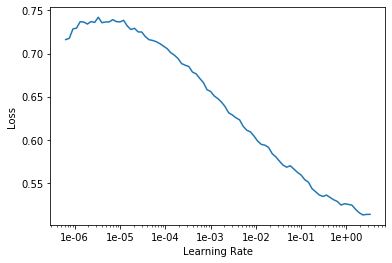

In [55]:
learn = getlearn()
learn.opt_func = optf_adam
learn.lr_find()
learn.recorder.plot()

In [56]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.537512,0.673003,0.673003,0.577600,0.362814,00:43
1,0.496501,0.480625,0.480625,0.695043,0.412130,00:42
2,0.459644,0.328490,0.328490,0.692735,0.556367,00:42
3,0.386793,0.250233,0.250233,0.835298,0.616732,00:42
4,0.322920,0.470282,0.470282,1.543848,0.369673,00:43
5,0.275181,0.311829,0.311829,1.338466,0.529710,00:43
6,0.245175,0.246989,0.246989,1.640386,0.615743,00:42
7,0.213537,0.194699,0.194699,0.543641,0.685413,00:42
8,0.189658,0.174415,0.174415,1.038536,0.712113,00:42
9,0.167762,0.140198,0.140198,0.751412,0.757339,00:42


Better model found at epoch 0 with valid_loss value: 0.6730028986930847.
Better model found at epoch 1 with valid_loss value: 0.4806247651576996.
Better model found at epoch 2 with valid_loss value: 0.3284897804260254.
Better model found at epoch 3 with valid_loss value: 0.2502334713935852.
Better model found at epoch 6 with valid_loss value: 0.24698877334594727.
Better model found at epoch 7 with valid_loss value: 0.19469943642616272.
Better model found at epoch 8 with valid_loss value: 0.17441478371620178.
Better model found at epoch 9 with valid_loss value: 0.1401984989643097.
Better model found at epoch 11 with valid_loss value: 0.11481285095214844.
Better model found at epoch 13 with valid_loss value: 0.0872698649764061.
Better model found at epoch 14 with valid_loss value: 0.08725808560848236.
Better model found at epoch 18 with valid_loss value: 0.07185699045658112.
Better model found at epoch 21 with valid_loss value: 0.06715203821659088.
Better model found at epoch 25 with val

In [57]:
backup_train_logs(tag)

In [ ]:
epochs:113,train_loss:0.023,mask_iou:0.918

### 阶段结果：
2000数据集效果最好，mask_iou 0.984.在28轮的时候就到了0.955，耗时约112min。143轮到达0.98，耗时约572min。最后在256轮的时候停止。  

200数据集mask_iou 0.922,240轮，耗时约88min。  

200+et(elastic transform)数据集，mask_iou 0.918,113轮，耗时约79min。

其中200+et数据集虽然数量多于200数据集，但是效果并没有更好，不过收敛要略快一些。

## 比较allres和vanila

### 200数据集，无transform，resnet18，vanila，dice，adam

In [93]:
tag = '__'.join(['resnet18', 'vanila', 'dice_loss', 'dataset200','adam'])

In [94]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                   , loss_func_name = 'dice_loss', allres = False, tag = tag)

In [80]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [32]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.576685,0.772869,0.772869,0.801760,0.000000,00:33
1,0.399787,0.819375,0.819375,0.978611,0.000000,00:23
2,0.318971,0.912573,0.912573,1.469705,0.000000,00:23
3,0.281842,0.818690,0.818690,1.331423,0.000515,00:24
4,0.260006,0.183279,0.183279,0.487018,0.712198,00:24
5,0.232149,0.203520,0.203520,0.738799,0.667679,00:23
6,0.205030,0.097140,0.097140,0.332182,0.830428,00:23
7,0.183030,0.253476,0.253476,1.106604,0.602793,00:23
8,0.167124,0.156643,0.156643,0.685680,0.751681,00:23
9,0.152730,0.180903,0.180903,0.601902,0.696833,00:23


Better model found at epoch 0 with valid_loss value: 0.7728694081306458.
Better model found at epoch 4 with valid_loss value: 0.1832788586616516.
Better model found at epoch 6 with valid_loss value: 0.09714015573263168.
Better model found at epoch 12 with valid_loss value: 0.08770924806594849.
Better model found at epoch 15 with valid_loss value: 0.08284346759319305.
Better model found at epoch 16 with valid_loss value: 0.07922443002462387.
Better model found at epoch 18 with valid_loss value: 0.07636988162994385.
Better model found at epoch 20 with valid_loss value: 0.07416640222072601.
Better model found at epoch 23 with valid_loss value: 0.06058864668011665.
on end of epoch#32: start annealing from 0.001 to 0.0001
Better model found at epoch 40 with valid_loss value: 0.0589120015501976.
Better model found at epoch 41 with valid_loss value: 0.05789027363061905.
Better model found at epoch 42 with valid_loss value: 0.05774946138262749.
Better model found at epoch 43 with valid_loss va

In [35]:
backup_train_logs(tag)

In [ ]:
epochs:144,train_loss:0.019,mask_iou:0.916

### 阶段结果  
vanlia得到的mask_iou略低于allres，收敛快于allres，144:240epochs

## 比较dice和balance_bce

### 200数据集，无transform，resnet18，allresh，balance_bce，adam，balance_ratio=1

In [81]:
tag = '__'.join(['resnet18', 'allres', 'balance_bce', 'dataset200','adam', 'balance_ratio_1'])

In [82]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
            , loss_func_name = 'balance_bce', allres = True, balance_ratio = 1, tag = tag)

In [83]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [40]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.614686,0.685084,0.720879,0.685084,0.307355,00:22
1,0.567236,0.671655,0.720669,0.671655,0.017879,00:22
2,0.540802,0.613617,0.685822,0.613617,0.365067,00:22
3,0.526255,0.514447,0.611106,0.514447,0.425178,00:22
4,0.504923,0.467339,0.581368,0.467339,0.471608,00:22
5,0.478278,0.334012,0.460968,0.334012,0.604405,00:22
6,0.445903,0.277304,0.403558,0.277304,0.678554,00:22
7,0.405267,0.312291,0.396872,0.312291,0.652147,00:22
8,0.368486,0.216927,0.293845,0.216927,0.667931,00:22
9,0.339699,0.517806,0.329220,0.517806,0.560916,00:22


Better model found at epoch 0 with valid_loss value: 0.6850839257240295.
Better model found at epoch 1 with valid_loss value: 0.6716548204421997.
Better model found at epoch 2 with valid_loss value: 0.6136173009872437.
Better model found at epoch 3 with valid_loss value: 0.5144469141960144.
Better model found at epoch 4 with valid_loss value: 0.46733856201171875.
Better model found at epoch 5 with valid_loss value: 0.3340119421482086.
Better model found at epoch 6 with valid_loss value: 0.2773037254810333.
Better model found at epoch 8 with valid_loss value: 0.2169274389743805.
Better model found at epoch 10 with valid_loss value: 0.1666257083415985.
Better model found at epoch 12 with valid_loss value: 0.1479007452726364.
Better model found at epoch 13 with valid_loss value: 0.1400548666715622.
Better model found at epoch 17 with valid_loss value: 0.1121641993522644.
Better model found at epoch 20 with valid_loss value: 0.10273797810077667.
Better model found at epoch 25 with valid_lo

In [41]:
backup_train_logs(tag)

In [ ]:
epochs:139,train_loss:0.019,mask_iou:0.908

#### 同样的resnet18,200数据集，adam，allres情况下，balance_bce(balance_ratio=1)的mask_iou=0.908低于dice_loss的0.922.收敛速度快于dice_loss 139:240epochs

### 200数据集，无transform，resnet18，vanila，balance_bce，adam，balance_ratio=10

In [84]:
tag = '__'.join(['resnet18', 'vanila', 'balance_bce', 'dataset200','adam', 'balance_ratio_10'])

In [85]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                , loss_func_name = 'balance_bce', allres = False, balance_ratio = 10, tag = tag)

In [86]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [46]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.666880,1.076214,0.760752,0.763481,0.000000,00:23
1,0.425888,0.821837,0.733969,0.699618,0.000000,00:23
2,0.315044,0.671926,0.713530,0.669372,0.411075,00:23
3,0.264489,0.413788,0.638105,0.547537,0.304217,00:23
4,0.229734,0.148682,0.472243,0.332627,0.463245,00:23
5,0.200230,0.094716,0.454933,0.476458,0.430457,00:23
6,0.175635,0.127277,0.493930,0.679007,0.362405,00:23
7,0.159654,0.075649,0.379768,0.332332,0.480609,00:23
8,0.143693,0.115664,0.464226,0.615209,0.378262,00:23
9,0.132258,0.112356,0.240325,0.168519,0.688671,00:23


Better model found at epoch 0 with valid_loss value: 1.0762139558792114.
Better model found at epoch 1 with valid_loss value: 0.8218368291854858.
Better model found at epoch 2 with valid_loss value: 0.6719263792037964.
Better model found at epoch 3 with valid_loss value: 0.4137875437736511.
Better model found at epoch 4 with valid_loss value: 0.14868196845054626.
Better model found at epoch 5 with valid_loss value: 0.09471604973077774.
Better model found at epoch 7 with valid_loss value: 0.07564861327409744.
Better model found at epoch 12 with valid_loss value: 0.06260214000940323.
Better model found at epoch 16 with valid_loss value: 0.06159978359937668.
Better model found at epoch 23 with valid_loss value: 0.05364485830068588.
Better model found at epoch 29 with valid_loss value: 0.05122267082333565.
Better model found at epoch 30 with valid_loss value: 0.0489858016371727.
Better model found at epoch 34 with valid_loss value: 0.0456542894244194.
on end of epoch#40: start annealing fr

In [47]:
backup_train_logs(tag)

#### balance_ratio=10比1的时候差了很多(虽然现在是一个allres一个vanlia)，mask_iou只有0.855

### 200数据集，无transform，resnet18，vanila,balance_bce,adam,balance_ratio=0.1

In [88]:
tag = '__'.join(['resnet18', 'vanila', 'balance_bce', 'dataset200','adam', 'balance_ratio_0.1'])

In [89]:
getlearn = partial(get_learn, data = data_200, model_name = 'resnet18'
                , loss_func_name = 'balance_bce', allres = False, balance_ratio = 0.1, tag = tag)

In [90]:
getlearn()

Learner(data=ImageDataBunch;

Train: LabelList (160 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Valid: LabelList (40 items)
x: SegmentationItemList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: SegmentationLabelList
ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512),ImageSegment (1, 512, 512)
Path: data/dataset_20200715/image;

Test: None, model=DataParallel(
  (module): Resnet_UNet(
    (down_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [91]:
lrs = [1e-3]
checkpoints = [None]
opts = [optf_adam]

nb_train_script_logger.multi_train(get_learn=getlearn, 
            epoch_len=1e9, epochs=500,
            opts=opts, lrs=lrs, checkpoints=checkpoints,
            tb_log_root='./tb_log/',
            autoSave=True)

ALLERT: You are using CumtomEpochLength, please make sure that your training dataloader is using random sampler, or this may cause problem.


epoch,train_loss,valid_loss,dice_loss,balance_bce,mask_iou,time
0,0.365479,0.391350,0.811735,0.830813,0.000000,00:24
1,0.252936,0.426894,0.802151,0.787218,0.000000,00:23
2,0.195103,0.494709,0.787298,0.730750,0.000000,00:23
3,0.161218,0.363366,0.735809,0.643231,0.000000,00:23
4,0.141486,0.170961,0.577545,0.574355,0.243317,00:23
5,0.119871,0.098694,0.344217,0.466001,0.594101,00:23
6,0.106421,0.053720,0.154652,0.200183,0.816914,00:23
7,0.095234,0.060293,0.189680,0.239017,0.796879,00:23
8,0.087838,0.109010,0.325130,0.514044,0.578363,00:23
9,0.089138,0.559830,0.367759,0.323072,0.489625,00:23


Better model found at epoch 0 with valid_loss value: 0.3913504183292389.
Better model found at epoch 3 with valid_loss value: 0.36336639523506165.
Better model found at epoch 4 with valid_loss value: 0.1709609478712082.
Better model found at epoch 5 with valid_loss value: 0.09869351983070374.
Better model found at epoch 6 with valid_loss value: 0.05372047424316406.
Better model found at epoch 14 with valid_loss value: 0.049166422337293625.
Better model found at epoch 28 with valid_loss value: 0.046037591993808746.
Better model found at epoch 33 with valid_loss value: 0.03559652715921402.
Better model found at epoch 44 with valid_loss value: 0.03517285734415054.
on end of epoch#49: start annealing from 0.001 to 0.0001
Better model found at epoch 57 with valid_loss value: 0.03382079303264618.
Better model found at epoch 86 with valid_loss value: 0.03381175547838211.
on end of epoch#94: start annealing from 0.0001 to 1e-05
on end of epoch#151: start annealing from 1e-05 to 1.0000000000000

In [92]:
backup_train_logs(tag)

### banlance_bce总体低于dice，balance_ratio=1的时候最好

# export

In [58]:
!python notebook2script.py --fname 'train_eval.ipynb' --outputDir './exp/'

Converted train_eval.ipynb to exp/nb_train_eval.py
